<a href="https://colab.research.google.com/github/Yash-Jumde/Colab-Notebooks/blob/main/Transfer_Learning_p3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The objective of this notebook is to get a model working on small amounts of data and then scale it up to a larger amount.

Usually the work flow should be:
Small dataset + small model --> larger dataset + small model --> Larger dataset + larger model --> extra large dataset + extra large model --> everything

In [ ]:
!nvidia-smi

Sat May 25 14:06:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import datetime
print(datetime.datetime.now())

2024-05-25 14:06:58.565670


In [ ]:
# importing helper functions

!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
# Importing all functions from 'helper_functions.py'

from helper_functions import *

In [ ]:
# Downloading small amounts of data (10% of the actual data)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-05-25 14:07:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.181.207, 64.233.183.207, 173.194.193.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.181.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  28.3MB/s    in 15s     

2024-05-25 14:07:19 (106 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bruschetta'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/red_velvet_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/creme_brulee'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bibimbap'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/peking_duck'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/churros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 directories and 75 images in '101

In [ ]:
# setup of data inputs

import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE)
# setting shuffle = False to get repetable evaluation metrics.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
# setting up checkpoint callback
checkpoint_path = "101_classes_10_percent_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)

In [ ]:
# Creating a data augmentation model

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # preprocessing.Rescaling(1./255) --> used for ResNet50V2
], name='data_augmentation')

In [ ]:
# Setting up the base model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=IMG_SIZE + (3,), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(len(train_data_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 101)               129381

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history_10_percent = model.fit(train_data_10_percent,
                               epochs=5,
                               validation_data=test_data,
                               validation_steps=int(0.15 * len(test_data)), # evaluates on smaller portion of test data
                               callbacks=[checkpoint_callback])


Epoch 1/5
237/237 [==============================] - 161s 630ms/step - loss: 3.3629 - accuracy: 0.2725 - val_loss: 2.5312 - val_accuracy: 0.4481
Epoch 2/5
237/237 [==============================] - 110s 464ms/step - loss: 2.1963 - accuracy: 0.4973 - val_loss: 2.0800 - val_accuracy: 0.4950
Epoch 3/5
237/237 [==============================] - 91s 383ms/step - loss: 1.8205 - accuracy: 0.5626 - val_loss: 1.9239 - val_accuracy: 0.5132
Epoch 4/5
237/237 [==============================] - 83s 349ms/step - loss: 1.5990 - accuracy: 0.6144 - val_loss: 1.8518 - val_accuracy: 0.5220
Epoch 5/5
237/237 [==============================] - 78s 329ms/step - loss: 1.4472 - accuracy: 0.6424 - val_loss: 1.7978 - val_accuracy: 0.5360


In [ ]:
results_feature_extractor_10_percent = model.evaluate(test_data)
results_feature_extractor_10_percent

790/790 [==============================] - 59s 74ms/step - loss: 1.5770 - accuracy: 0.5847


[1.5770010948181152, 0.584673285484314]

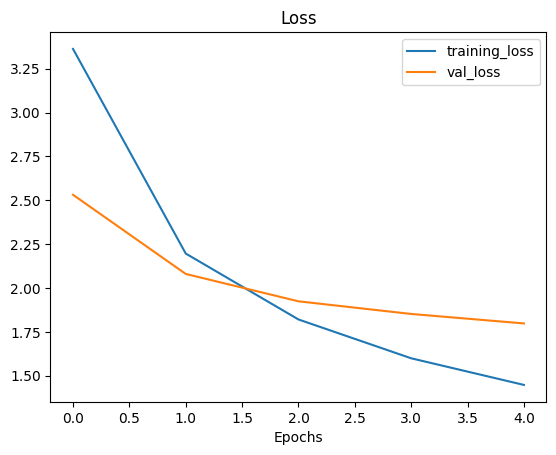

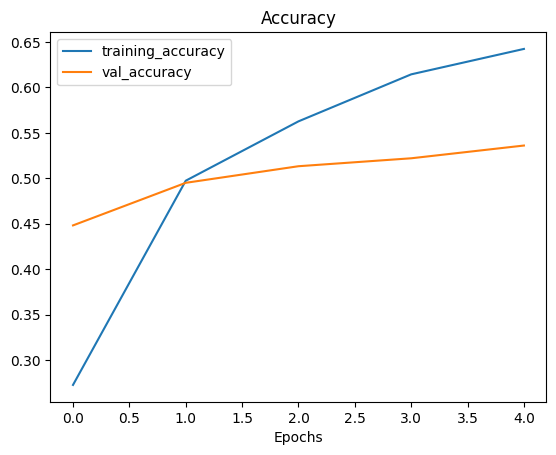

In [ ]:
plot_loss_curves(history_10_percent)

In [ ]:
# We have now done 'feature extraction'
# We will proceed for 'fine-tuning'

In [ ]:
# unfreezing all layers of the base model
base_model.trainable = True

# refreezing every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), # learning rate lowered to ensure updates to the previous trained weights aren't too large
              metrics=['accuracy'])

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
# we  can clearly see that only the last 5 layers are trainable

In [ ]:
fine_tune_epochs = 10

history_10_percent_fine_tune = model.fit(train_data_10_percent,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           initial_epoch=history_10_percent.epoch[-1],
                                           callbacks=[checkpoint_callback])

Epoch 5/10
237/237 [==============================] - 85s 321ms/step - loss: 1.2085 - accuracy: 0.6912 - val_loss: 1.7419 - val_accuracy: 0.5434
Epoch 6/10
237/237 [==============================] - 66s 276ms/step - loss: 1.1029 - accuracy: 0.7053 - val_loss: 1.7343 - val_accuracy: 0.5485
Epoch 7/10
237/237 [==============================] - 62s 262ms/step - loss: 1.0216 - accuracy: 0.7312 - val_loss: 1.7217 - val_accuracy: 0.5487
Epoch 8/10
237/237 [==============================] - 60s 251ms/step - loss: 0.9577 - accuracy: 0.7426 - val_loss: 1.7336 - val_accuracy: 0.5503
Epoch 9/10
237/237 [==============================] - 59s 243ms/step - loss: 0.9064 - accuracy: 0.7547 - val_loss: 1.7337 - val_accuracy: 0.5482
Epoch 10/10
237/237 [==============================] - 59s 247ms/step - loss: 0.8344 - accuracy: 0.7764 - val_loss: 1.7096 - val_accuracy: 0.5572


In [ ]:
results_feature_extractor_10_percent_fine_tune = model.evaluate(test_data)
results_feature_extractor_10_percent_fine_tune

790/790 [==============================] - 60s 75ms/step - loss: 1.4903 - accuracy: 0.6045


[1.4903223514556885, 0.6044752597808838]

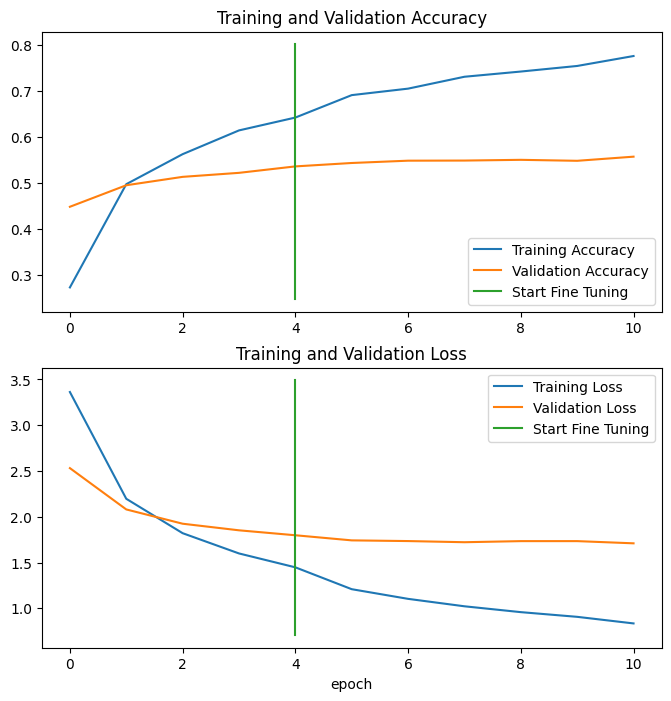

In [ ]:
compare_historys(history_10_percent, history_10_percent_fine_tune, initial_epochs=5)

In [ ]:
# the validation accuracy and loss become constant after some point
# This might be due to the model overfitting the data.

In [ ]:
# saving this trained model
model.save("drive/My Drive/10_percent_fine_tuned_model")

In [ ]:
# let's try to use the saved model further by loading it
saved_model_path = "drive/My Drive/10_percent_fine_tuned_model"
loaded_model = tf.keras.models.load_model(saved_model_path)

In [ ]:
loaded_loss, loaded_accuracy = loaded_model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 64s 79ms/step - loss: 1.4903 - accuracy: 0.6045


(1.4903223514556885, 0.6044752597808838)

Here are the results before:
790/790 [==============================] - 56s 70ms/step - loss: 1.5082 - accuracy: 0.6004
[1.508202075958252, 0.6004356145858765]

And, here are the results now:
790/790 [==============================] - 65s 80ms/step - loss: 1.5082 - accuracy: 0.6004
(1.508202075958252, 0.6004356145858765)

In [ ]:
# Evaluating the model or making predictions with it
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 67s 81ms/step


In [ ]:
len(pred_probs)

25250

In [ ]:
pred_probs.shape

(25250, 101)

In [ ]:
pred_probs[:2]

array([[1.04881771e-01, 1.91285435e-04, 6.35027811e-02, 1.31013380e-07,
        2.44207276e-05, 2.35352172e-06, 2.35475207e-04, 1.45075376e-06,
        2.08120719e-02, 1.47666957e-04, 2.00239720e-06, 2.73289947e-06,
        1.89371742e-04, 3.64100003e-07, 1.48295257e-02, 2.83119315e-03,
        5.42583512e-05, 1.89183222e-03, 3.18976026e-03, 7.89288242e-06,
        1.21815724e-03, 1.20281993e-05, 1.90552004e-04, 1.84704142e-04,
        3.88720189e-04, 3.69112869e-03, 3.69419024e-04, 8.09047051e-05,
        3.81149888e-01, 1.21987553e-03, 1.49998084e-06, 6.70533977e-04,
        8.53321631e-04, 1.08922666e-06, 6.57484168e-03, 7.27377483e-06,
        7.65904915e-05, 1.60942355e-03, 5.66685759e-02, 4.18928888e-04,
        5.02655283e-04, 6.19881204e-04, 6.97442505e-04, 3.42237536e-06,
        2.28784585e-04, 1.58879920e-05, 1.17860956e-03, 1.47966799e-04,
        5.50963421e-07, 7.16543347e-02, 6.22072039e-05, 3.82776634e-05,
        3.77479456e-02, 3.08366828e-02, 7.89053411e-06, 6.788513

In [ ]:
# 101 predictions for each image

In [ ]:
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"Prediction probability 0: {pred_probs[0]}")
print(f"Highest predicted probability by the model: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
Prediction probability 0: [1.0488177e-01 1.9128543e-04 6.3502781e-02 1.3101338e-07 2.4420728e-05
 2.3535217e-06 2.3547521e-04 1.4507538e-06 2.0812072e-02 1.4766696e-04
 2.0023972e-06 2.7328995e-06 1.8937174e-04 3.6410000e-07 1.4829526e-02
 2.8311932e-03 5.4258351e-05 1.8918322e-03 3.1897603e-03 7.8928824e-06
 1.2181572e-03 1.2028199e-05 1.9055200e-04 1.8470414e-04 3.8872019e-04
 3.6911287e-03 3.6941902e-04 8.0904705e-05 3.8114989e-01 1.2198755e-03
 1.4999808e-06 6.7053398e-04 8.5332163e-04 1.0892267e-06 6.5748417e-03
 7.2737748e-06 7.6590492e-05 1.6094235e-03 5.6668576e-02 4.1892889e-04
 5.0265528e-04 6.1988120e-04 6.9744251e-04 3.4223754e-06 2.2878459e-04
 1.5887992e-05 1.1786096e-03 1.4796680e-04 5.5096342e-07 7.1654335e-02
 6.2207204e-05 3.8277663e-05 3.7747946e-02 3.0836683e-02 7.8905341e-06
 6.7885132e-03 2.5174251e-02 1.5664856e-03 1.6338269e-03 4.5514149e-05
 3.1235984e-07 5.2186418e-03 1.2217657e-02 6.1288435e-04 5.2765303e-0

In [ ]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes

array([ 28,   0,   0, ..., 100, 100, 100])

In [ ]:
y_labels = []
for images, labels in test_data.unbatch(): # Unbatching the test data to get images and labels
  y_labels.append(labels.numpy().argmax()) # appending the largest value
y_labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
# These are in order as they are unshuffled
len(y_labels)

25250

In [ ]:
# Evaluation Metrics
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6044752475247525

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  # If classes is passed, confusion matrix will be labelled otherwise integer values will be used

  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # Normalize
  n_classes = cm.shape[0] # to find the number of classes to be dealt with

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # Color map (darker == better)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title='Confusion Matrix',
         xlabel='Predicted Label',
         ylabel='True Label',
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will be labeled with class names
         yticklabels=labels)

  # X-axis labels
  ax.xaxis.set_label_position('bottom')
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=70, fontsize=text_size) # rotating for better readability
  plt.yticks(fontsize=text_size)

  # Set threshold
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
               horizontalalignment='center',
               color='white' if cm[i, j] > threshold else 'black',
               size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
               horizontalalignment='center',
               color='white' if cm[i, j] > threshold else 'black',
               size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
# converting labels to class names

In [ ]:
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
make_confusion_matrix(y_labels,
                      pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [ ]:
# Classification Report?
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.36      0.22      0.27       250
           1       0.54      0.71      0.61       250
           2       0.75      0.56      0.65       250
           3       0.90      0.50      0.64       250
           4       0.55      0.43      0.48       250
           5       0.43      0.50      0.46       250
           6       0.72      0.80      0.76       250
           7       0.85      0.75      0.80       250
           8       0.27      0.56      0.37       250
           9       0.39      0.66      0.49       250
          10       0.53      0.42      0.47       250
          11       0.86      0.54      0.66       250
          12       0.69      0.64      0.66       250
          13       0.62      0.49      0.55       250
          14       0.49      0.61      0.54       250
          15       0.36      0.43      0.39       250
          16       0.67      0.55      0.60       250
          17       0.33    

In [ ]:
# Visualizing this
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.3576158940397351,
  'recall': 0.216,
  'f1-score': 0.26932668329177056,
  'support': 250},
 '1': {'precision': 0.5379939209726444,
  'recall': 0.708,
  'f1-score': 0.61139896373057,
  'support': 250},
 '2': {'precision': 0.7540106951871658,
  'recall': 0.564,
  'f1-score': 0.6453089244851258,
  'support': 250},
 '3': {'precision': 0.8992805755395683,
  'recall': 0.5,
  'f1-score': 0.6426735218508998,
  'support': 250},
 '4': {'precision': 0.5515463917525774,
  'recall': 0.428,
  'f1-score': 0.481981981981982,
  'support': 250},
 '5': {'precision': 0.4261168384879725,
  'recall': 0.496,
  'f1-score': 0.4584103512014787,
  'support': 250},
 '6': {'precision': 0.7230215827338129,
  'recall': 0.804,
  'f1-score': 0.7613636363636365,
  'support': 250},
 '7': {'precision': 0.8468468468468469,
  'recall': 0.752,
  'f1-score': 0.7966101694915254,
  'support': 250},
 '8': {'precision': 0.27079303675048355,
  'recall': 0.56,
  'f1-score': 0.3650586701434159,
  'support': 25

In [ ]:
class_f1_scores = {}

for k, v in classification_report_dict.items():
  if k == 'accuracy':
    break
  else:
    class_f1_scores[class_names[int(k)]] = v['f1-score']
class_f1_scores

{'apple_pie': 0.26932668329177056,
 'baby_back_ribs': 0.61139896373057,
 'baklava': 0.6453089244851258,
 'beef_carpaccio': 0.6426735218508998,
 'beef_tartare': 0.481981981981982,
 'beet_salad': 0.4584103512014787,
 'beignets': 0.7613636363636365,
 'bibimbap': 0.7966101694915254,
 'bread_pudding': 0.3650586701434159,
 'breakfast_burrito': 0.4888888888888889,
 'bruschetta': 0.4674157303370786,
 'caesar_salad': 0.6617283950617284,
 'cannoli': 0.6638830897703548,
 'caprese_salad': 0.5491071428571429,
 'carrot_cake': 0.5448028673835126,
 'ceviche': 0.39194139194139194,
 'cheese_plate': 0.6035242290748899,
 'cheesecake': 0.40610687022900765,
 'chicken_curry': 0.4883720930232558,
 'chicken_quesadilla': 0.6457023060796646,
 'chicken_wings': 0.7325102880658436,
 'chocolate_cake': 0.558659217877095,
 'chocolate_mousse': 0.36397748592870544,
 'churros': 0.6845878136200716,
 'clam_chowder': 0.7295597484276729,
 'club_sandwich': 0.683982683982684,
 'crab_cakes': 0.4100719424460432,
 'creme_brulee':

In [ ]:
# now converting the f1-score dictionary into a pandas DataFrame
import pandas as pd
f1_scores_df = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                             "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores_df

class_name  f1-score
33         edamame  0.964706
63        macarons  0.901639
69         oysters  0.861996
75             pho  0.858268
45   frozen_yogurt  0.844262
..             ...       ...
39       foie_gras  0.333333
82         ravioli  0.319192
50  grilled_salmon  0.315789
93           steak  0.281818
0        apple_pie  0.269327

[101 rows x 2 columns]

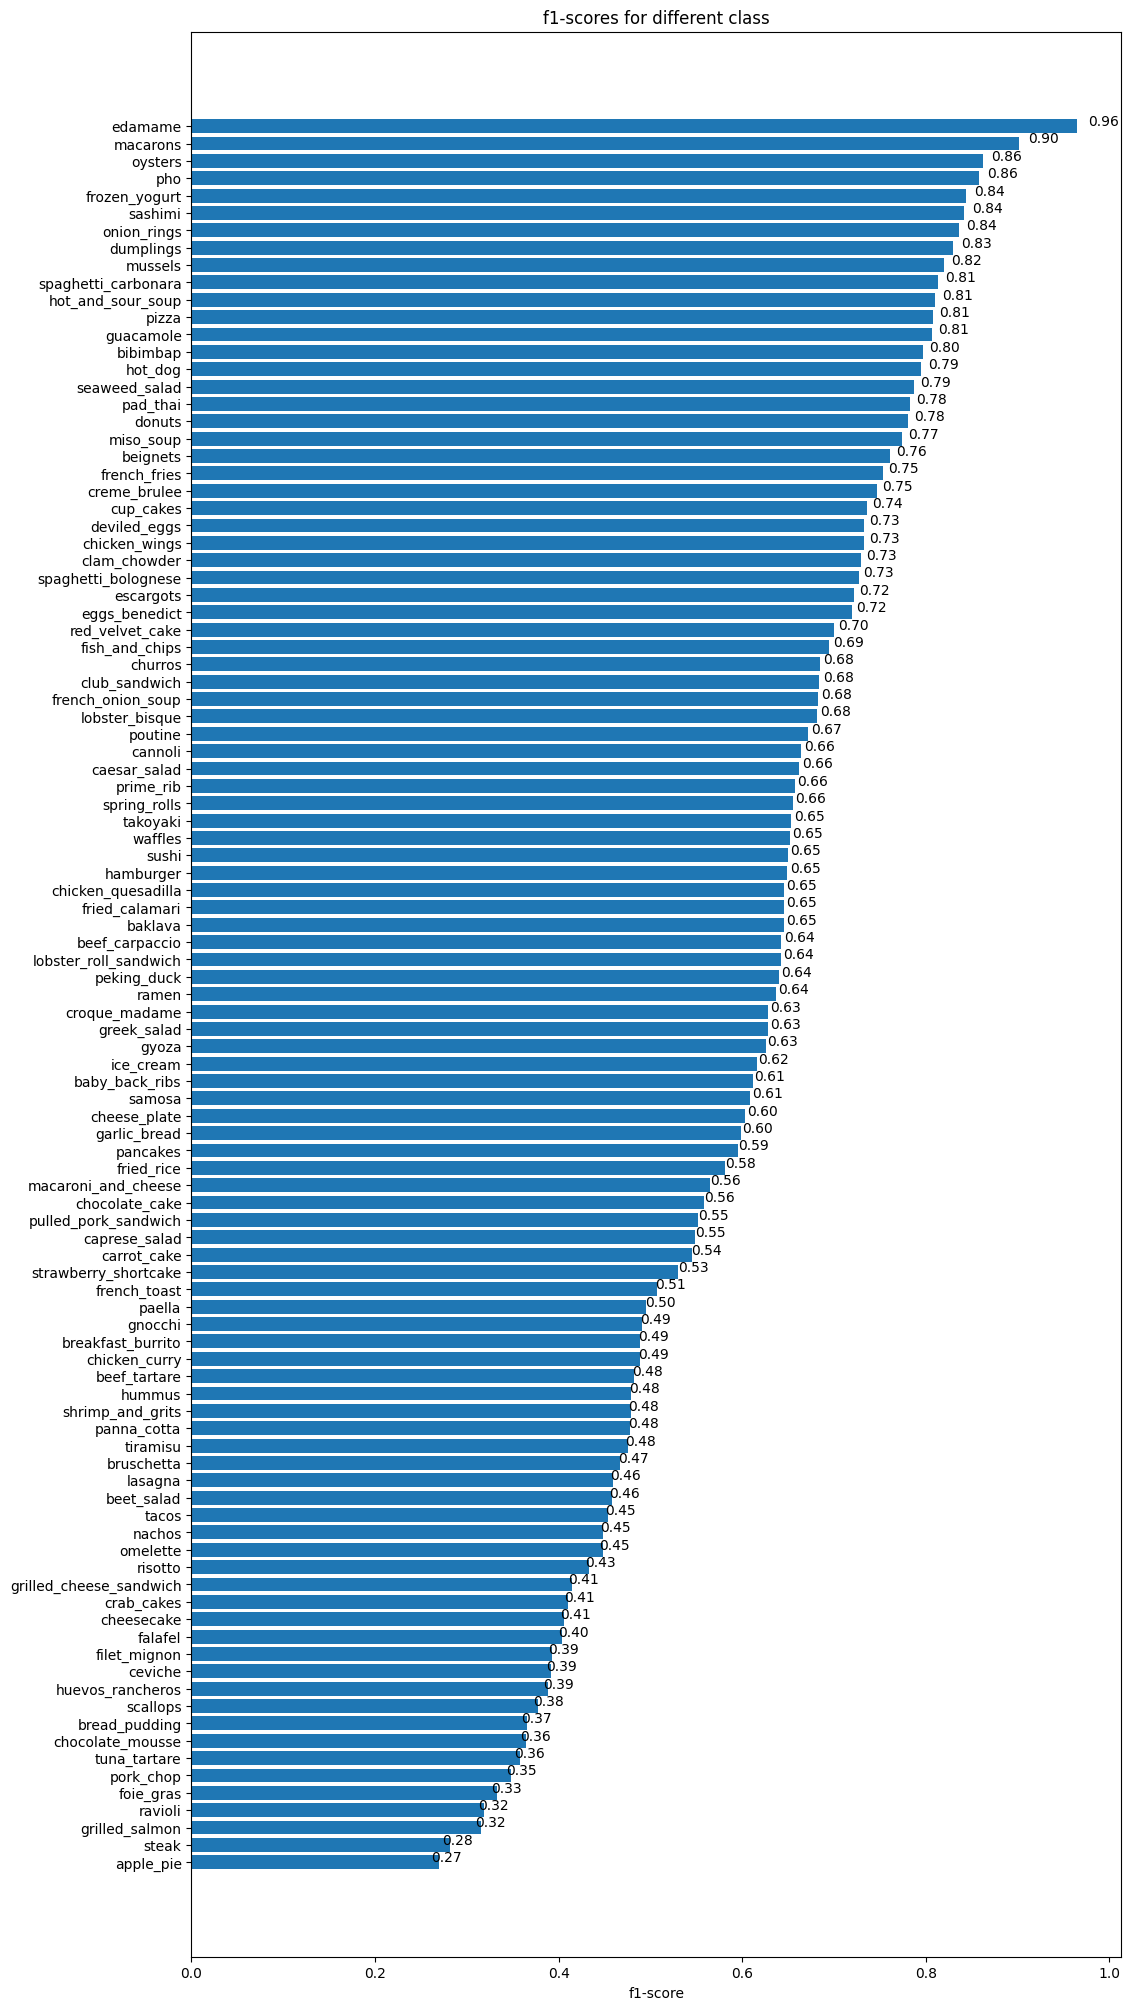

In [ ]:
# More visualization

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores_df)), f1_scores_df['f1-score'].values)
ax.set_yticks(range(len(f1_scores_df)))
ax.set_yticklabels(list(f1_scores_df['class_name']))
ax.set_xlabel('f1-score')
ax.set_title('f1-scores for different class')
ax.invert_yaxis()

def autolabel(rects):
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

The model seems to be performing poorly on classes such as aaple_pie and pork_chop etc. while appears to be outstanding on classes such as edamame and pho etc.

In [ ]:
# testing model on new images

def load_and_prep_image(filename, img_shape=224, scale=True):
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img)
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    return img/255.
  else:
    return img

In [ ]:
# Now we will load a few random images.
# Then make predictions on them.
# then plot the original image with model's label, pred_prob and true label

1/1 [==============================] - 0s 30ms/step


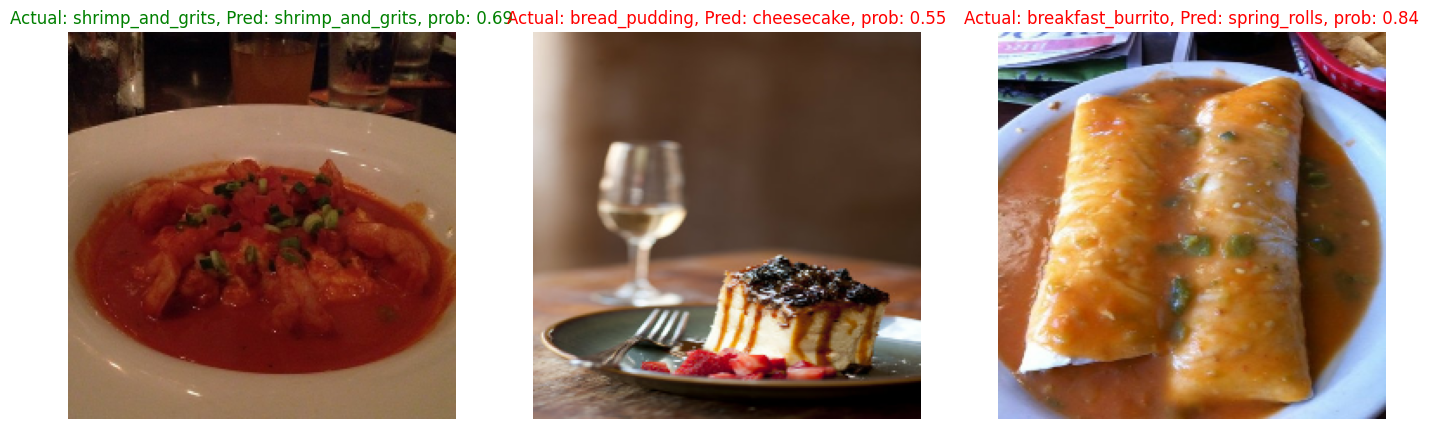

In [ ]:
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + class_name))
  filepath = test_dir + class_name + "/" + filename

  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # expanding dimensions as model accepts tensors of shape (None, 224, 224, 3)
  pred_class = class_names[pred_prob.argmax()]

  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"Actual: {class_name}, Pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False)

The model makes worse predictions on classes which are visually similar.

In [ ]:
# Predictions where the model has predicted high but the prediction is still wrong

In [ ]:
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
pred_df = pd.DataFrame({"img_path": filepaths,
                       "y_true": y_labels,
                       "y_pred": pred_classes,
                       "pred_conf": pred_probs.max(axis=1),
                       "y_true_class": [class_names[i] for i in y_labels],
                       "y_pred_class": [class_names[i] for i in pred_classes]})
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      28   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_class          y_pred_class  
0   0.381150    apple_pie         croque_madame  
1   0.970691    apple_pie             apple_pie  
2   0.596673    apple_pie             apple_pie  
3   0.219443    apple_pie  pulled_pork_sandwich  
4   0.512931    apple_pie         bread_pudding

In [ ]:
pred_df['pred_correct'] = pred_df['y_true'] == pred_df['y_pred']
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      28   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_class          y_pred_class  pred_correct  
0   0.381150    apple_pie         croque_madame         False  
1   0.970691    apple_pie             apple_pie          True  
2   0.596673    apple_pie             apple_pie          True  
3   0.219443    apple_pie  pulled_pork_sandwich         False  
4   0.512931    apple_pie         bread_pudding         False

In [ ]:
# Get the most wrongly predicted examples
top_wrong = pred_df[pred_df['pred_correct'] == False].sort_values("pred_conf", ascending=False)[:100]
top_wrong.head(25)

img_path  y_true  y_pred  \
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
15142  b'101_food_classes_10_percent/test/lobster_bis...      60      64   
15425  b'101_food_classes_10_percent/test/lobster_rol...      61      80   
15826  b'101_food_classes_10_percent/test/macarons/19...      63      29   
5114   b'101_food_classes_10_percent/test/chicken_win...      20      38   
14255  b'101_food_classes_10_percent/test/hummus/1071...      57      49   
722    b'101_food_classes_10_percent/test/baklava/640...       2      85   
10346  b'101_food_classes_10_percent/test/french_onio...      41      54   
24479  b'101_food_classes_10_percent/test/takoyaki/68...      97      78   
10880  b'101_food_classes_10_percent/test/fried_calam...      43      68   
191    b'101_food_classes_10_percent/test/apple_pie/3...       0      31   
12487  b'101_food_classes_10_percent/test/grilled_che...      49      25   
7295   b'101_food_classes_10_percent/test/cup_cakes/1...      29      31   
4613   b'101_food_classes_10_percent/test/chicken_cur...      18      54   
10854  b'101_food_classes_10_percent/test/fried_calam...      43      68   
22     b'101_food_classes_10_percent/test/apple_pie/1...       0     100   
10741  b'101_food_classes_10_percent/test/french_toas...      42       1   
14482  b'101_food_classes_10_percent/test/hummus/8476...      57      51   
23300  b'101_food_classes_10_percent/test/steak/17945...      93       1   
6108   b'101_food_classes_10_percent/test/clam_chowde...      24      27   

       pred_conf             y_true_class             y_pred_class  \
23797   0.999232                    sushi                  sashimi   
18001   0.999041                 pancakes                 omelette   
21810   0.998369                 scallops                cup_cakes   
11642   0.997574             garlic_bread               bruschetta   
10847   0.997223           fried_calamari              onion_rings   
23631   0.996373     strawberry_shortcake          red_velvet_cake   
15142   0.995727           lobster_bisque                miso_soup   
15425   0.995241    lobster_roll_sandwich     pulled_pork_sandwich   
15826   0.994742                 macarons                cup_cakes   
5114    0.994642            chicken_wings           fish_and_chips   
14255   0.993680                   hummus  grilled_cheese_sandwich   
722     0.992831                  baklava                   samosa   
10346   0.992274        french_onion_soup        hot_and_sour_soup   
24479   0.992121                 takoyaki                  poutine   
10880   0.991304           fried_calamari              onion_rings   
191     0.990293                apple_pie                   donuts   
12487   0.989630  grilled_cheese_sandwich            club_sandwich   
7295    0.989277                cup_cakes                   donuts   
4613    0.989179            chicken_curry        hot_and_sour_soup   
10854   0.987642           fried_calamari              onion_rings   
22      0.987403                apple_pie                  waffles   
10741   0.987363             french_toast           baby_back_ribs   
14482   0.986666                   hummus                guacamole   
23300   0.986466                    steak           baby_back_ribs   
6108    0.985668             clam_chowder             creme_brulee   

       pred_correct  
23797         False  
18001         False  
21810         False  
11642         False  
10847         False  
23631         False  
15142         False  
15425         False  
15826         False  
5114          False  
14255   

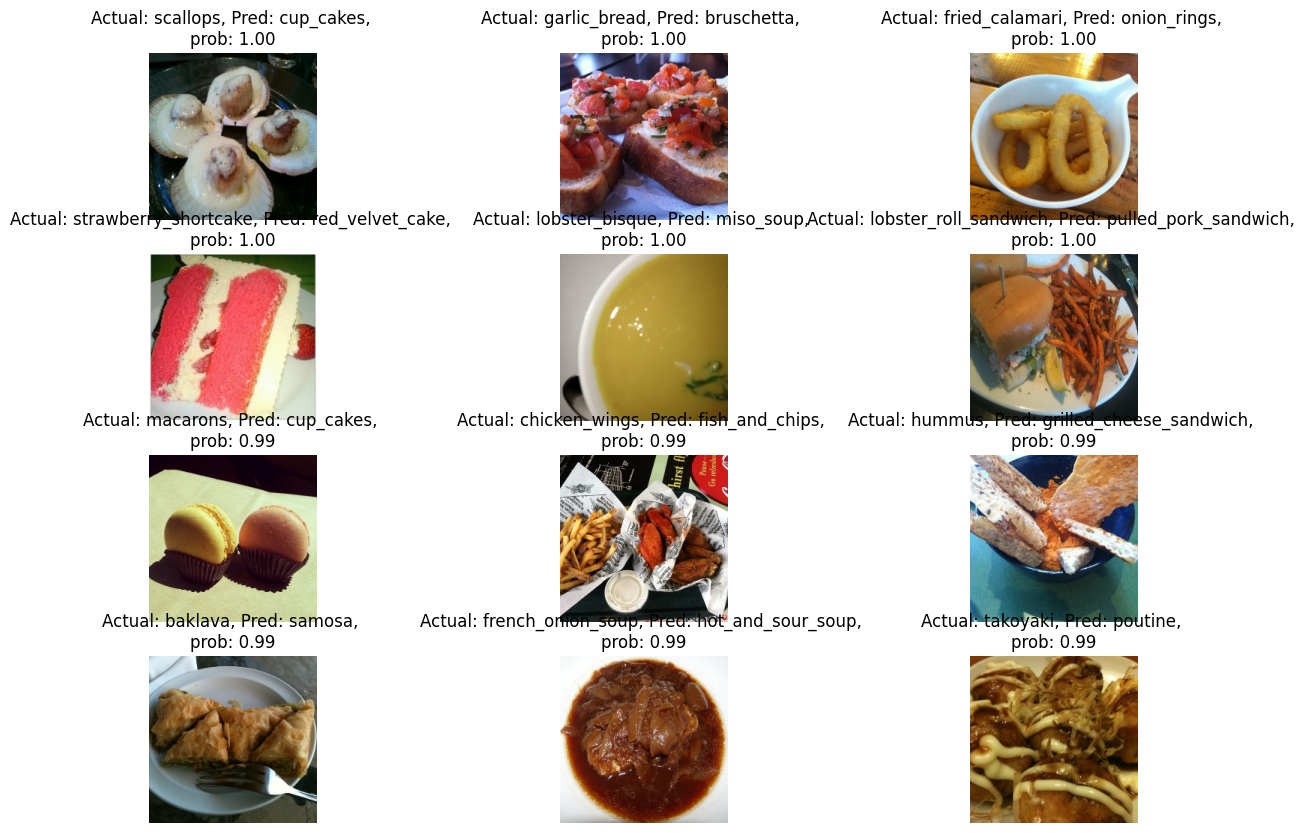

In [ ]:
# Visualizing the wrong examples
images_to_view = 12
start_index = 2
plt.figure(figsize=(15,10))
for i, row in enumerate(top_wrong[start_index:start_index + images_to_view].itertuples()):
  plt.subplot(4, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row
  plt.imshow(img)
  plt.title(f"Actual: {y_true}, Pred: {y_pred}, \nprob: {pred_prob:.2f}")
  plt.axis(False)

In [ ]:
# Testing the model on some custom images

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2024-05-25 14:31:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.207, 173.194.194.207, 173.194.195.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  57.6MB/s    in 0.2s    

2024-05-25 14:31:55 (57.6 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
custom_food_images = ['custom_food_images/' + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/steak.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg']

1/1 [==============================] - 0s 28ms/step


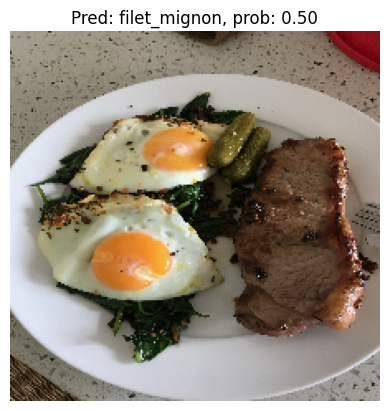

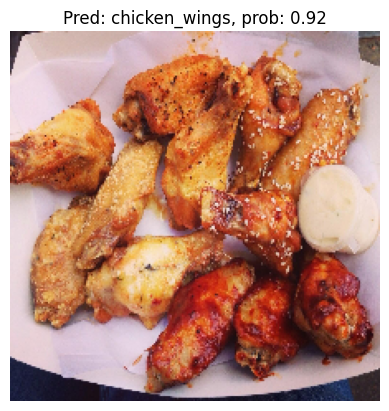

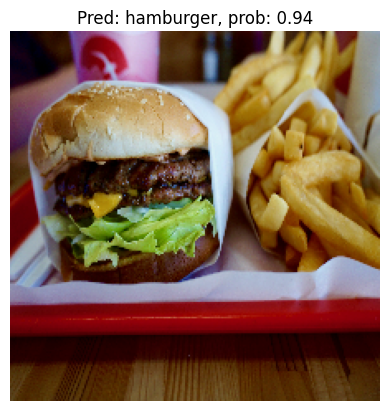

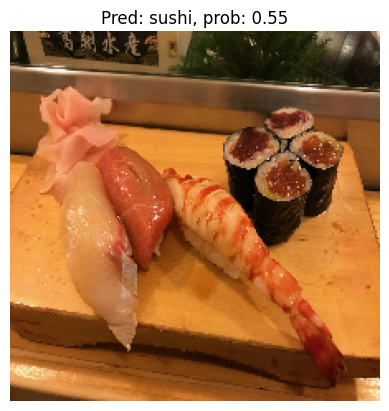

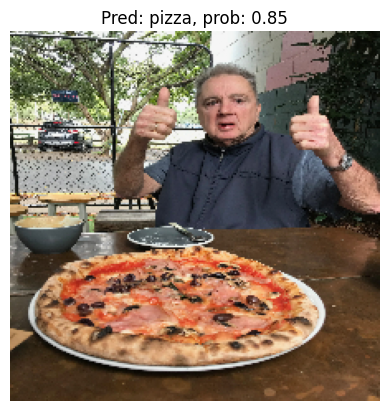

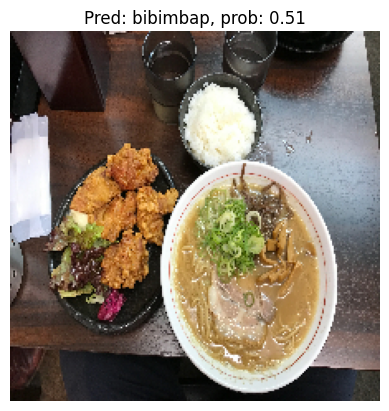

In [ ]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale = False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"Pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)